In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

----- Первые 5 строк данных -----
   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Source  
0      0         A/5 21171   7.2500   NaN        S  train  
1      0          PC 17599  71.2833   C85        C  train  
2      0  STON/O2. 3101282   7.9250   NaN        S  train  
3      0            113803  53.1000  C123     

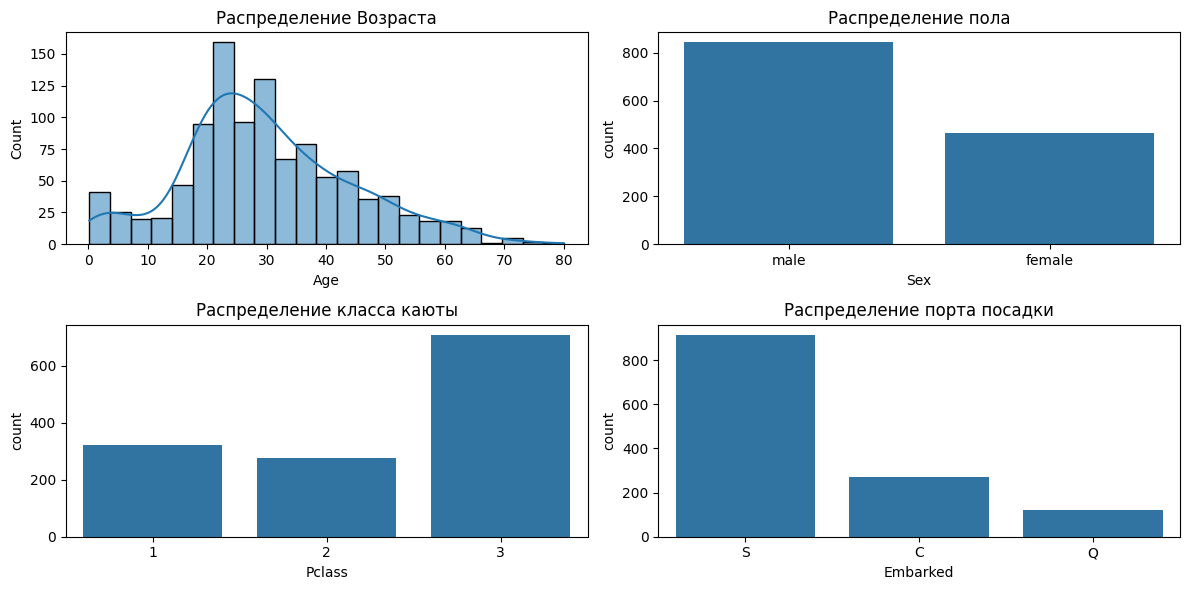

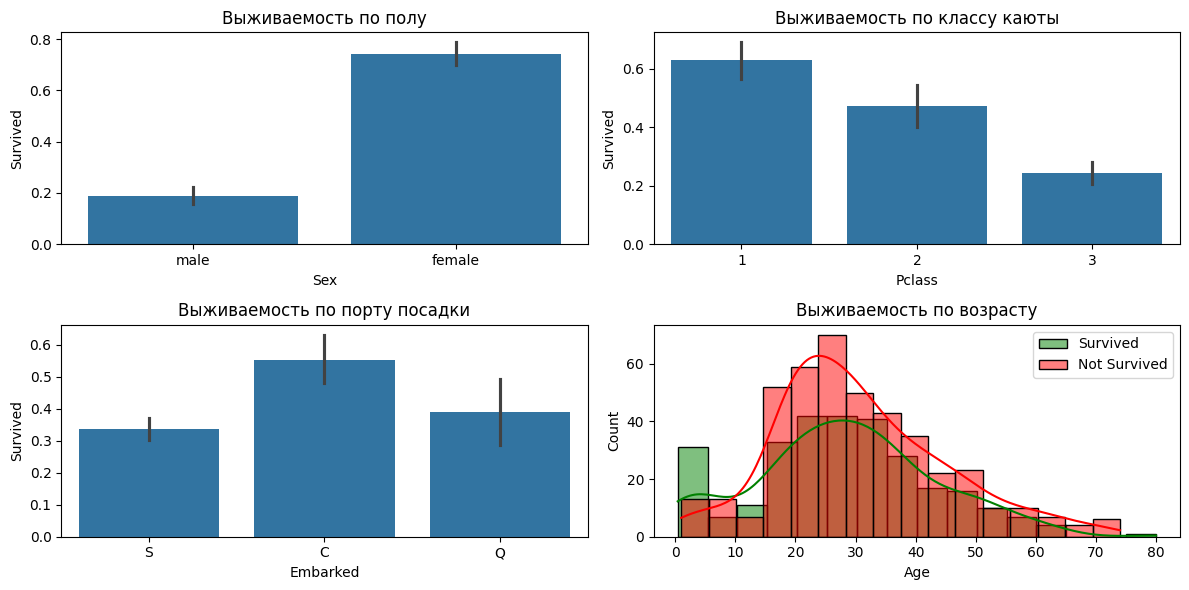

In [2]:
# -----------------------------------------------------------------------------
# 1. Загрузка данных и EDA
# -----------------------------------------------------------------------------
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
gender_submission_df = pd.read_csv('gender_submission.csv')

# Объединим train и test для удобства EDA (потом разделим обратно)
train_df['Source'] = 'train'
test_df['Source'] = 'test'
all_df = pd.concat([train_df, test_df], ignore_index=True)

print("----- Первые 5 строк данных -----")
print(all_df.head())

print("\n----- Информация о данных -----")
print(all_df.info())

print("\n----- Статистика по числовым признакам -----")
print(all_df.describe())

print("\n----- Статистика по категориальным признакам -----")
print(all_df.describe(include=['O']))

# Визуализация распределения признаков
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(all_df['Age'].dropna(), kde=True)
plt.title('Распределение Возраста')

plt.subplot(2, 2, 2)
sns.countplot(x='Sex', data=all_df)
plt.title('Распределение пола')

plt.subplot(2, 2, 3)
sns.countplot(x='Pclass', data=all_df)
plt.title('Распределение класса каюты')

plt.subplot(2, 2, 4)
sns.countplot(x='Embarked', data=all_df)
plt.title('Распределение порта посадки')

plt.tight_layout()
plt.show()

# Анализ влияния признаков на выживаемость
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Выживаемость по полу')

plt.subplot(2, 2, 2)
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title('Выживаемость по классу каюты')

plt.subplot(2, 2, 3)
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.title('Выживаемость по порту посадки')

plt.subplot(2, 2, 4)
sns.histplot(train_df[train_df['Survived'] == 1]['Age'].dropna(), kde=True, color='green', label='Survived')
sns.histplot(train_df[train_df['Survived'] == 0]['Age'].dropna(), kde=True, color='red', label='Not Survived')
plt.title('Выживаемость по возрасту')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
# -----------------------------------------------------------------------------
# 2. Предварительная обработка данных
# -----------------------------------------------------------------------------
# Восстановим train и test
train_df = all_df[all_df['Source'] == 'train'].drop('Source', axis=1)
test_df = all_df[all_df['Source'] == 'test'].drop('Source', axis=1)

# Заполнение пропущенных значений
for df in [train_df, test_df]:
    df['Age'] = df['Age'].fillna(df['Age'].median())  # Заполняем медианой
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])  # Заполняем модой
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())  # Заполняем медианой

# Создание новых признаков
for df in [train_df, test_df]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', \
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Кодирование категориальных признаков
for df in [train_df, test_df]:
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    df['Title'] = df['Title'].map({'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Other': 5}).astype(int)

# Удаление ненужных столбцов
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

<>:18: SyntaxWarning: invalid escape sequence '\.'
<>:18: SyntaxWarning: invalid escape sequence '\.'
/var/folders/z0/z13j0s9x43dcdm5j4kjr4ykc0000gn/T/ipykernel_11529/1465570195.py:18: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)



----- Результаты модели -----
Точность: 0.8156424581005587
Отчет о Классификации:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       105
         1.0       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179

Матрица Конфузии:
[[93 12]
 [21 53]]


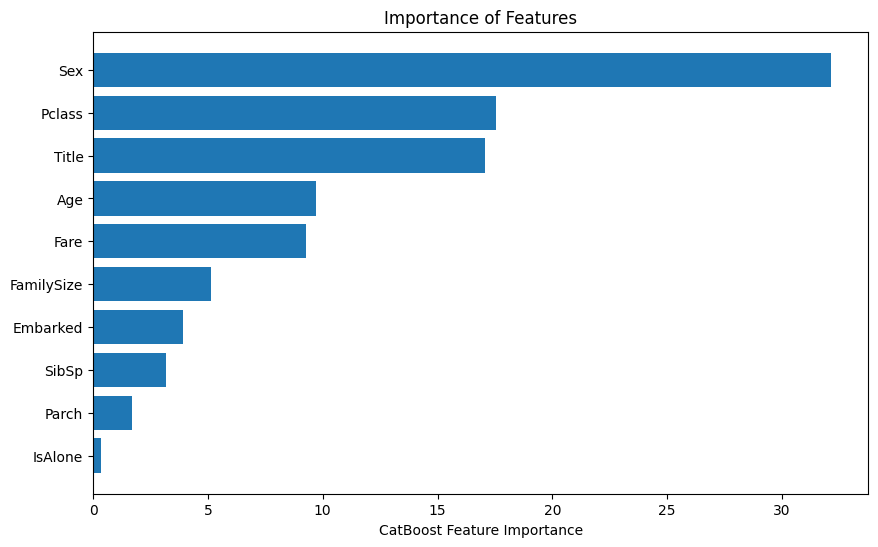

In [4]:
# -----------------------------------------------------------------------------
# 3. Построение и оценка модели без GridSearchCV
# -----------------------------------------------------------------------------

# Разделение данных на обучающую и тестовую выборки
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели CatBoost с фиксированными параметрами
model = CatBoostClassifier(
    iterations=200,          # Количество итераций (можно увеличить для улучшения качества)
    learning_rate=0.05,      # Скорость обучения
    depth=6,                 # Глубина деревьев
    random_seed=42,          # Фиксируем случайное состояние для воспроизводимости
    logging_level='Silent',  # Отключаем лишние логи
    early_stopping_rounds=10 # Ранняя остановка для ускорения обучения
)

# Обучение модели
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# Оценка модели
y_pred = model.predict(X_test)
print('\n----- Результаты модели -----')
print('Точность:', accuracy_score(y_test, y_pred))
print('Отчет о Классификации:')
print(classification_report(y_test, y_pred))
print('Матрица Конфузии:')
print(confusion_matrix(y_test, y_pred))

# Важность признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("CatBoost Feature Importance")
plt.title("Importance of Features")
plt.show()

In [5]:
# -----------------------------------------------------------------------------
# 4. Предсказание на тестовой выборке и сохранение результатов
# -----------------------------------------------------------------------------
# Подготовка тестовой выборки
X_test_final = test_df.drop('Survived', axis=1)

# Предсказание на тестовой выборке
test_pred = model.predict(X_test_final)

# Сохранение результатов
output = pd.DataFrame({'PassengerId': gender_submission_df['PassengerId'], 'Survived': test_pred})
output.to_csv('gender_submission.csv', index=False)
print("Результаты сохранены в файл submission.csv")

Результаты сохранены в файл submission.csv
